<a href="https://colab.research.google.com/github/eduardoheros/pauta_explicativa/blob/master/Pauta_explicativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install spanish_sentiment_analysis
!pip install stanza
from classifier import SentimentClassifier
clasificador=SentimentClassifier()
import stanza
stanza.download('es')
stanza = stanza.Pipeline('es')
from scipy.stats import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))

In [ ]:
##Se construye una función de tal forma que para SentimentClassifier()
##Valores menores a 0.4 tengan una escala de -1 a 0, siendo -1 más negativo
##Valores mayores a 0.6 tengan una escala de 0 a 1, siendo 1 más positivo
##Valores entre 0.4 y 0.6 tengan un valor 0, considerador neutros

def sentimiento(texto):
  x=clasificador.predict(texto)
  if x<0.4:
    return 2.5*x-1
  elif x>0.6:
    return 2.5*x-1.5
  else:
    return 0

In [ ]:
##Diccionario de palabras que cumplen características buscadas

##Valor 1

permanente_words=["siempre","nunca","eterno","eternamente","constante","constantemente","continua","continuamente",
                  "invariable","invariablemente","jamas","jamás","ultimo","último","imperecederamente","imperecedero",
                  "perder","ganar","interminable","borrar","concluir","romper","ser"]
penetrante_words=["el","todo","universo","completo","completamente","mundo","nada","nadie","ningun","ninguno","total","totalmente",
                  "destino","muerto","fin","peor","mejor","hasta","tan","revolucion","pleno","plenamente","conquistar","transformar"]
internalizado_words=["yo","soy","nosotros","somos","nos","me"]

##Valor -1

temporal_words=["veces","vez","ocasion","ocasionalmente","situacion","momento","momentaneamente",
                "momentaneo","situacion","circunstancial","circunstancia","casual","casualmente",
                "provisional","provisionalmente","efimero","ahora","actualmente","actual","hoy",
                "recientemente","reciente","entonces","pasajero","dia","día","estar"]
especifico_words=["este","ocasion","solo","solamente","unico","unicamente","exclusivo","exclusivamente","singular","singularmente"]
externalizado_words=["ellos","ellas","los","ella","el"]

##Excepciones (No utilizadas...en desarrollo)
adverbios_negacion=["nunca","jamas","no","nadie","nada","ningun","ninguno","ninguna","ni","rehuso","tampoco","ni siquiera"]
palabras_negativas=["vencido","vencida","vencidos","vencidas","derrotado","derrotada","derrotado","derrotadas"]
palabras_positivas=["hemos vencido","he vencido","hemos derrotado","he derrotado"]

In [ ]:
##Permanencia: 1 permanente, -1 temporal
def permanencia(sentence):
  lista=[]
  for i in sentence.words:
    lemma=i.lemma
    lista.append(lemma)
  for i in lista:
    if i in permanente_words:
      permanencia=1
      break
    elif i in temporal_words:
      permanencia=-1
      break
    else:
      permanencia=0
  return permanencia    

In [ ]:
##Alcance: 1 penetrante, -1 especifico
def alcance(sentence):
  lista=[]
  for i in sentence.words:
    if i.feats!=None:
      if not ("PronType=Prs" in i.feats):
        lemma=i.lemma
        lista.append(lemma)
  for i in lista:
    if i in especifico_words:
      alcance=-1
      break
    elif i in penetrante_words:
      alcance=1
      break
    else:
      alcance=0
  return alcance    

In [ ]:
#@title
'''
Codigo no utilizado
###Personalización: 1 interno, 2 externo
def locus(sentence):
  lista=[]
  polaridad=1
  cantidad_palabras=len(sentence.to_dict())
  for i in sentence.words:
    if i.upos=="ADV":
      if i.head > 0:
        if (i.lemma in adverbios_negacion) and (sentence.words[i.head-1].lemma in internalizado_words):
          locus=2
          polaridad=-1
          lista.append(locus)
        elif (i.lemma in adverbios_negacion) and (sentence.words[i.head-1].lemma in externalizado_words):
          locus=1
          polaridad=-1
          lista.append(locus)          
      elif 1<i.id:
        if (i.lemma in adverbios_negacion) and ("Person=1" in sentence.words[i.id-1].feats):
          locus=2
          polaridad=-1
          lista.append(locus)
        elif (i.lemma in adverbios_negacion) and ("Person=2" in sentence.words[i.id-1].feats):
          locus=1
          polaridad=-1
          lista.append(locus)
        elif (i.lemma in adverbios_negacion) and ("Person=3" in sentence.words[i.id-1].feats):
          locus=1
          polaridad=-1
          lista.append(locus)
      elif i.id<cantidad_palabras:
        if (i.lemma in adverbios_negacion) and ("Person=1" in sentence.words[i.id+1].feats):
          locus=2
          polaridad=-1
          lista.append(locus)
        elif (i.lemma in adverbios_negacion) and ("Person=2" in sentence.words[i.id+1].feats):
          locus=1
          polaridad=-1
          lista.append(locus)
        elif (i.lemma in adverbios_negacion) and ("Person=3" in sentence.words[i.id+1].feats):
          locus=1
          polaridad=-1
          lista.append(locus)
    elif i.upos=="PRON":
      if i in internalizado_words:
        locus=1
        lista.append(locus)
      elif i in externalizado_words:
        locus=2
        lista.append(locus)
    elif "Person=1" in i.feats:
      locus=1
      lista.append(locus)
    elif "Person=2" in i.feats:
      locus=1
      lista.append(locus)
    elif "Person=3" in i.feats:
      locus=1
      lista.append(locus)
  locus=mode(lista).mode[0]    
  return locus, polaridad,lista
  '''

In [ ]:
##Personalización: 1 interno, -1 externo
def locus(sentence):
  lista=[]
  for i in sentence.words:
    if i.feats!=None:
      if "Person=1" in i.feats:
        lista.append(1)
      elif "Person=2" in i.feats:
        lista.append(-1)
      elif "Person=3" in i.feats:
        lista.append(-1)
  if len(lista)>0:
    locus=mode(lista).mode[0]
  else:
    locus=0
  return locus

In [ ]:
##Devuelve lista con puntaje de cada oración
def score_list(x):
  lista=[]
  texto=stanza(x)
  for sentence in texto.sentences:
    score=sentimiento(sentence.text)
    lista.append(score)
  return lista

In [ ]:
#@title
###Devuelve escala de optimismo, de -3 más pesimista, a -1 menos pesimista, 0 neutral, 1 optimista a 3 más optimista

'''
positivos, negativos = 0, 0
index = 0
# while loop
while(index < len(lista)):
   if lista[index] > 0:
      positivos += 1
   index += 1
   

def escala(sentimiento,permanencia, alcance, internalizacion):
  positivos, negativos = 0, 0
  index = 0
  lista=[sentimiento,permanencia,alcance,internalizacion]
  if sentimiento<0:
    while(index < len(lista)):
      if lista[index] > 0:
        positivos += 1
      index += 1
  elif sentimiento>0:
'''

In [ ]:
def analisis(texto):
  stanza_model=stanza(texto)
  valores=np.empty(0)
  n=len(stanza_model.sentences)

  for i in stanza_model.sentences:
    s=sentimiento(i.text)
    p=permanencia(i)
    a=alcance(i)
    l=locus(i)
    if s<0:
      escala_optimista=-(p+a+l)
    elif s>0:
      escala_optimista=p+a+l
    else:
      escala_optimista=0
    valores=np.append(valores,np.array([s,p,a,l,escala_optimista]))
  
  valores=valores.reshape(n,5)
  df=pd.DataFrame(data=valores,columns=["Sentimiento","Permanencia","Alcance","Locus","Escala Optimismo"])
      
  return df

In [ ]:
def resumen_puntajes(texto):
  df=analisis(texto)
  resumen=(df[df.Sentimiento>0].mean())+(df[df.Sentimiento<0].mean())
  return resumen

In [ ]:
nocturno_rosario="""Pues bien, yo necesito decirte que te quiero\n
Decirte que te adoro con todo el corazón\n
Que es mucho lo que sufro, que es mucho lo que lloro\n
Que ya no puedo tanto y al grito en que te imploro\n
Te imploro y te hablo en nombre de mi última ilusión\n
Yo quiero que tú sepas que ya hace muchos días\n
Estoy enfermo y pálido de tanto no dormir\n
Que ya se han muerto todas las esperanzas mías\n
Que están mis noches negras, tan negras y sombrías\n
Que ya no sé ni dónde se alzaba el porvenir\n
De noche, cuando pongo mis sienes en la almohada\n
Y hacia otro mundo quiero mi espíritu volver\n
Camino mucho, mucho, y al fin de la jornada\n
Las formas de mi madre se pierden en la nada\n
Y tú, de nuevo, vuelves en mi alma a aparecer\n
Comprendo que tus besos jamás han de ser míos\n
Comprendo que en tus ojos no me he de ver jamás\n
Y te amo, y en mis locos y ardientes desvaríos\n
Bendigo tus desdenes, adoro tus desvíos\n
Y, en vez de amarte menos, te quiero mucho más\n
A veces, pienso en darte mi eterna despedida\n
Borrarte en mis recuerdos y hundirte en mi pasión\n
Mas, si es en vano todo y el alma no te olvida\n
¿Qué quieres tú que yo haga, pedazo de mi vida?\n
¿Qué quieres tú que yo haga con este corazón?\n
Y luego que ya estaba concluido tu santuario\n
La lámpara encendida, tu velo en el altar\n
El sol de la mañana detrás del campanario\n
Chispeando las antorchas, humeando el incensario\n
Y abierta, allá a lo lejos, la puerta del hogar\n
¡Qué hermoso hubiera sido vivir bajo aquel techo!\n
Los dos unidos, siempre, y amándonos los dos\n
Tú, siempre enamorada; yo, siempre satisfecho\n
Los dos una sola alma, los dos un sólo pecho\n
Y, en medio de nosotros, mi madre como un Dios\n
Figúrate qué hermosas las horas de esa vida\n
¡Qué dulce y bello el viaje por una tierra así!\n
Y yo soñaba, en eso, mi santa prometida\n
Y al delirar en ello, con alma entristecida\n
Pensaba yo en ser bueno por ti, nomás por ti\n
Bien sabe Dios que ese era mi más hermoso sueño\n
Mi afán y mi esperanza, mi dicha y mi placer\n
Bien sabe Dios que en nada cifraba yo mi empeño\n
Sino en amarte mucho bajo el hogar risueño\n
Que me envolvió en sus besos cuando me vio nacer\n
Esa era mi esperanza\n
Mas, ya que a sus fulgores se opone el hondo abismo que existe entre los dos\n
Adiós, por la vez última, amor de mis amores\n
La luz de mis tinieblas, la esencia de mis flores\n
Mi lira de poeta, mi juventud, ¡adiós!"""

In [ ]:
discurso_presidente_nieto="""
Vamos hacia adelante.
Es tiempo de romper, juntos, los mitos y paradigmas, y todo aquello que ha limitado nuestro desarrollo.
La transformación nacional demanda la actuación responsable y decidida del Presidente de la República, pero requiere, también, de la energía creadora de todos los mexicanos.
Estamos a las puertas de una nueva etapa de nuestra historia. Nuestro país ha sido escenario de grandes movimientos que dejaron huella, reformistas unos, revolucionarios otros; estos movimientos han sacudido la conciencia nacional, para cambiar lo que no puede ni debe permanecer.
En el México de hoy, lo que no puede ni debe permanecer es la situación de pobreza y hambre en que se encuentra un amplio sector de nuestra población.
Al margen de nuestras legítimas, naturales y sanas diferencias, si todos aportamos nuestro trabajo y empeño, los mexicanos podemos construir un país plenamente desarrollado.
Ahora, es tiempo de construir y de ganar el futuro. Hagamos de México un país no sólo orgulloso de su pasado, sino un país empeñado en mejorar su presente y conquistar su futuro. Un país arrojado y audaz, preparado para competir y triunfar, para que esa sea su imagen ante el mundo entero.
Un México, como lo he señalado y expresado en reiteradas ocasiones, un México donde cada quien pueda escribir su propia historia de éxito y sea feliz. Un México así, es alcanzable, porque depende de nosotros, de cada uno y de todos.
En la vida de un país, seis años son un periodo corto, pero dos mil 191 días son suficientes para sentar las bases de lo que desde ahora debe ser nuestra meta: Hacer de México un país próspero, de oportunidades y de bienestar para todos.
Las naciones desarrolladas, en algún momento de su historia, decidieron dar un gran paso. Hoy, toca a los mexicanos dar ese gran paso.
Todo cambio profundo es resultado de creer, de creer en lo que hacemos, de creer en lo que somos, de creer en nosotros mismos, de tener confianza en lo que podemos, en lo que somos y podemos ser.
Por eso, convoco hoy a todos los mexicanos, a las mujeres y a los hombres, de todas las regiones y de todas las edades, de todos los orígenes, a ser parte de esta gran trasformación.
Transformar a México significa vencer los rezagos. Transformar a México implica mover todo lo que se tenga que mover: la gente, la mentalidad, las instituciones.
Hay que transformar a México, para que cuando nuestros hijos crezcan, disfruten de un país más grande y mejor del que hoy tenemos.
Seamos, todos, parte del México que no le tiene miedo a la transformación, del México dispuesto a trascender y a dejar huella. Nuestro país, nuestra Nación, necesita de todos.
El país se construye todos los días. En cada instante, en cada lugar, se va haciendo y construyendo México.
Trabajemos con determinación, con audacia y con pasión. Con la mirada puesta en el futuro.
Es tiempo de mover a México. Seamos parte de la generación que logre la transformación nacional.
Vienen, de eso estoy convencido, mejores tiempos para todos los mexicanos. Porque éste, éste es el momento de México.
Muchas gracias."""

In [ ]:
felicitaciones="""
Sigue dando lo mejor de ti siempre,
que con esta dedicación y esfuerzo,
podrás llegar hasta donde te lo propongas"""

In [ ]:
resumen_puntajes(discurso_presidente_nieto)

Sentimiento         0.062869
Permanencia         0.208333
Alcance             1.020833
Locus              -1.312500
Escala Optimismo    0.583333
dtype: float64

In [ ]:
resumen_puntajes(nocturno_rosario)

Sentimiento        -0.085320
Permanencia         0.365729
Alcance             0.861893
Locus              -0.455243
Escala Optimismo   -0.184143
dtype: float64

In [ ]:
analisis("Soy el culpable de mis desgracias")

,Sentimiento,Permanencia,Alcance,Locus,Escala Optimismo
0,-0.663912,1.0,1.0,1.0,-3.0


In [ ]:
analisis("Últimamente siempre estoy en mi peor momento")

,Sentimiento,Permanencia,Alcance,Locus,Escala Optimismo
0,-0.201263,1.0,1.0,1.0,-3.0


In [ ]:
analisis("Somos arquitectos de nuestro propio destino")

,Sentimiento,Permanencia,Alcance,Locus,Escala Optimismo
0,0.511191,1.0,1.0,1.0,3.0


In [ ]:
analisis("Nada más peligroso para la democracia que un gobierno débil, negador y conspirativo.")

,Sentimiento,Permanencia,Alcance,Locus,Escala Optimismo
0,-0.962426,0.0,1.0,0.0,-1.0


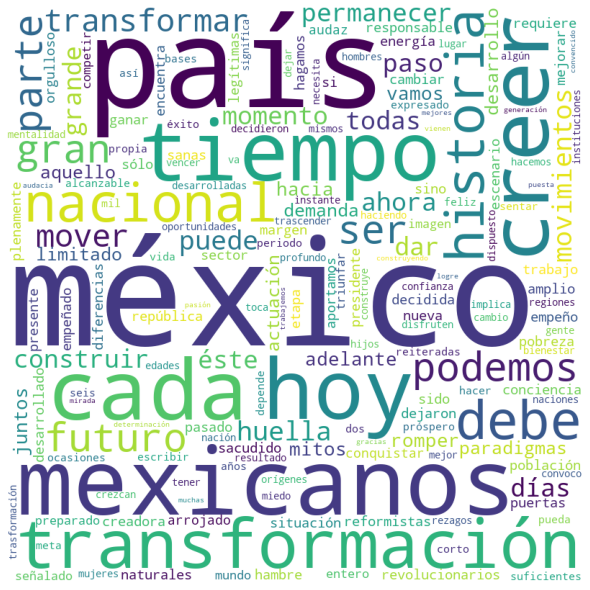

In [ ]:
tokens_discurso=stanza(discurso_presidente_nieto)
tokens=[]
comment_words = '' 
for i, sentence in enumerate(tokens_discurso.sentences):
    for token in sentence.tokens:
      tokens.append(token.text)
comment_words = '' 
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words_sp, 
                min_font_size = 10).generate(comment_words) 
  
                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

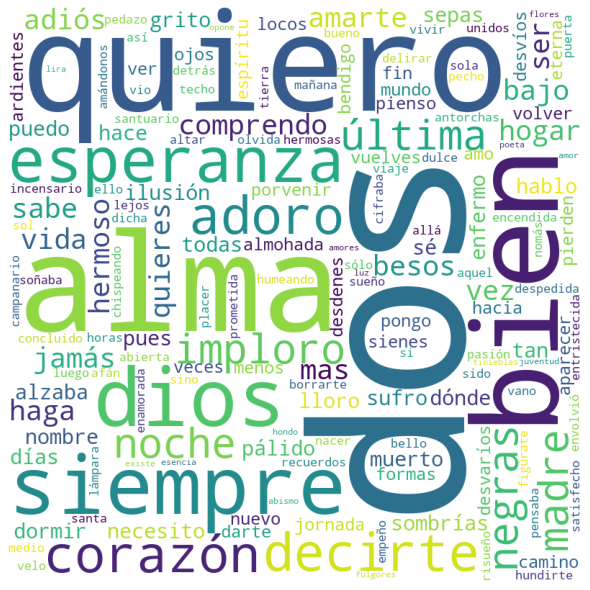

In [ ]:
tokens_rosario=stanza(nocturno_rosario)
tokens=[]
comment_words = '' 
for i, sentence in enumerate(tokens_rosario.sentences):
    for token in sentence.tokens:
      tokens.append(token.text)
comment_words = '' 
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words_sp, 
                min_font_size = 10).generate(comment_words) 
  
                 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 